#### 1. Setup


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

##### 1.1 Load Cleaned Datasets


In [4]:
# Load cleaned datasets
benin = pd.read_csv("../data/benin_clean.csv", parse_dates=["Timestamp"])
sierra = pd.read_csv("../data/sierraleone_clean.csv", parse_dates=["Timestamp"])
togo = pd.read_csv("../data/togo_clean.csv", parse_dates=["Timestamp"])

In [8]:
# Add Country Label
benin['Country'] = 'Benin'
sierra['Country'] = 'SierraLeone'
togo['Country'] = 'Togo'

In [9]:
# Combine datasets for comparison
df_all = pd.concat([benin, sierra, togo], ignore_index=True)

#### 2. Metric Comparison(Box plot)

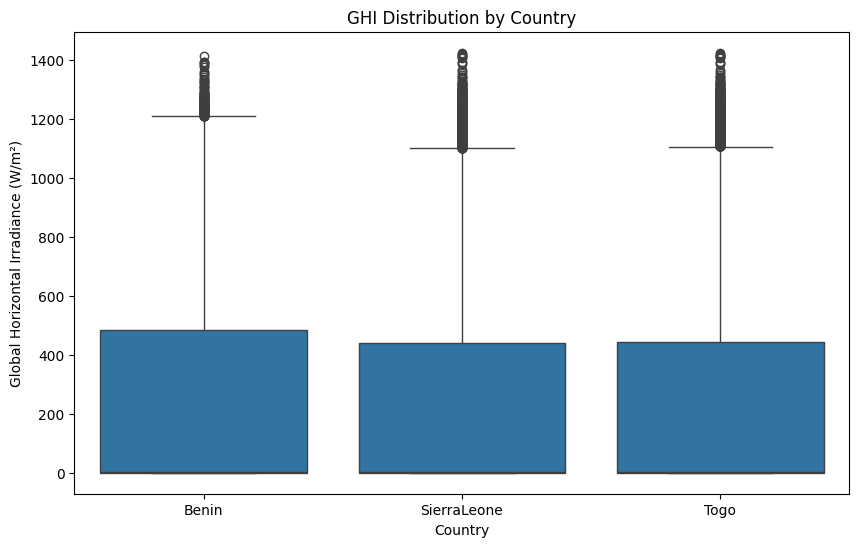

In [10]:
# GHI Boxplot by Country
plt.figure(figsize=(10, 6))
sns.boxplot(x='Country', y='GHI', data=df_all)
plt.title('GHI Distribution by Country') 
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.xlabel('Country')
plt.show()   

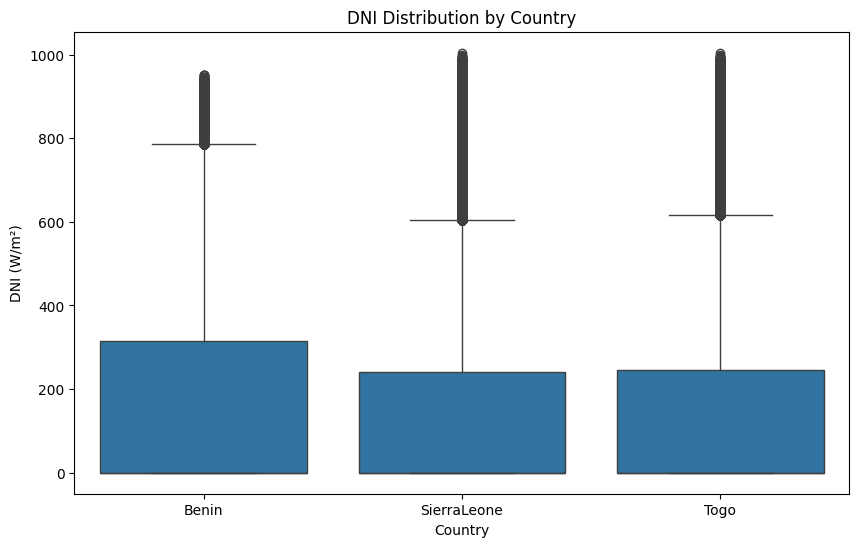

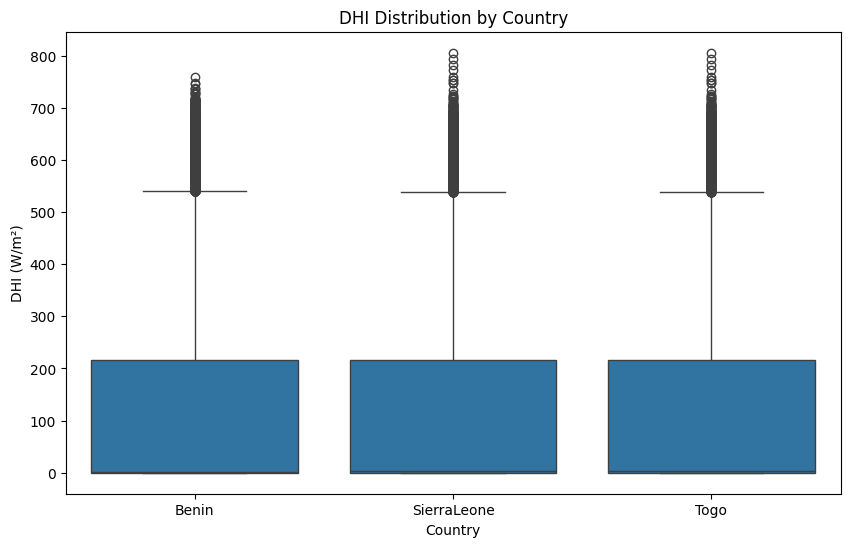

In [11]:
# For DNI and DHI
for metric in ['DNI', 'DHI']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Country', y=metric, data=df_all)
    plt.title(f'{metric} Distribution by Country') 
    plt.ylabel(f'{metric} (W/m²)')
    plt.xlabel('Country')
    plt.show()

#### 3. Summary Statistics Table
**KPI requirement**

**How to interpret**

1. Mean → energy planning

2. Median → robustness to extremes

3. Std → reliability / predictability

In [12]:
summary = (
    df_all
    .groupby('Country')[['GHI', 'DNI', 'DHI']]
    .agg(['mean', 'median', 'std'])
    .round(2)
)

summary

GHI                    DNI                    DHI         \
               mean median     std    mean median     std    mean median   
Country                                                                    
Benin        241.96    1.8  330.10  167.44    0.0  261.55  116.99    1.6   
SierraLeone  230.96    2.3  320.68  150.50    0.0  250.92  116.76    2.7   
Togo         231.72    2.1  321.69  151.26    0.0  250.96  116.44    2.5   

                     
                std  
Country              
Benin        157.46  
SierraLeone  157.07  
Togo         156.52

In [16]:
# Convert summary table into JSON-safe nested dict
summary_json = {}

for country in summary.index:
    summary_json[country] = {}
    for metric in ["GHI", "DNI", "DHI"]:
        summary_json[country][metric] = {
            "mean": float(summary.loc[country, (metric, "mean")]),
            "median": float(summary.loc[country, (metric, "median")]),
            "std": float(summary.loc[country, (metric, "std")])
        }

# Export to JSON
import json
with open("summary_statistics.json", "w") as f:
    json.dump(summary_json, f, indent=4)


In [17]:
with open("summary_statistics.json", "r") as f:
    data = json.load(f)

data

{'Benin': {'GHI': {'mean': 241.96, 'median': 1.8, 'std': 330.1},
  'DNI': {'mean': 167.44, 'median': 0.0, 'std': 261.55},
  'DHI': {'mean': 116.99, 'median': 1.6, 'std': 157.46}},
 'SierraLeone': {'GHI': {'mean': 230.96, 'median': 2.3, 'std': 320.68},
  'DNI': {'mean': 150.5, 'median': 0.0, 'std': 250.92},
  'DHI': {'mean': 116.76, 'median': 2.7, 'std': 157.07}},
 'Togo': {'GHI': {'mean': 231.72, 'median': 2.1, 'std': 321.69},
  'DNI': {'mean': 151.26, 'median': 0.0, 'std': 250.96},
  'DHI': {'mean': 116.44, 'median': 2.5, 'std': 156.52}}}

#### 4. Statistical Testing(ANOVA)
**ANOVA**
1. Comparing means of 3 independent groups
2. Null hypothesis: all means are equal

In [13]:
ghi_benin = benin['GHI']
ghi_sierra = sierra['GHI']  
ghi_togo = togo['GHI']

f_stat, p_value = stats.f_oneway(ghi_benin, ghi_sierra, ghi_togo)

print(f"ANOVA F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")

ANOVA F-statistic: 185.7677, p-value: 0.0000


**Interpretation***
1. p < 0.05 → statistically significant difference
2. p ≥ 0.05 → differences may be due to chance

#### 5. Key Observations

- **Benin exhibits the highest average solar potential** among the three countries, with the largest mean Global Horizontal Irradiance (GHI ≈ 241.96). However, it also shows the **greatest variability** (highest standard deviation), indicating more frequent extreme irradiance values and higher volatility in solar availability.

- **Sierra Leone and Togo display very similar solar profiles**, with nearly identical mean and variability levels across GHI, DNI, and DHI. This suggests comparable climatic and atmospheric conditions influencing solar radiation in these two countries.

- **Statistical testing confirms the differences are significant**: a one-way ANOVA on GHI values yields an F-statistic of **185.77** with a **p-value < 0.001**, indicating that observed differences in solar irradiance across countries are **not due to random variation** and are meaningful for solar site planning decisions.


#### 6. Ranking By Average GHI

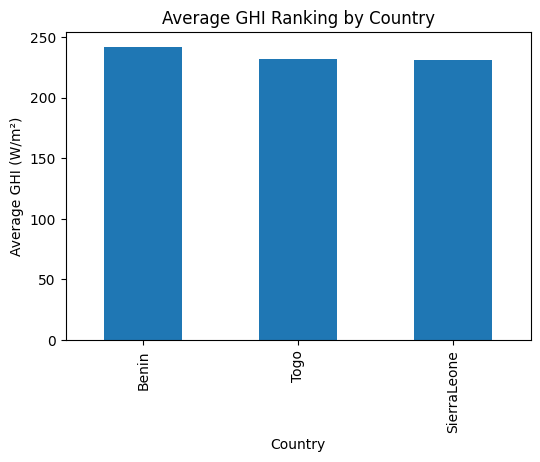

In [18]:
avg_ghi = (
    df_all.groupby("Country")["GHI"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(6,4))
avg_ghi.plot(kind="bar")
plt.ylabel("Average GHI (W/m²)")
plt.title("Average GHI Ranking by Country")
plt.show()
